![NFL Logo](nfl_logo.png)

# Analysis of NFL Play by Play Data
### By Pierson Polcaro
This is part of an assignment for CMSC320, Intro to Data Science, at the University of Maryland, College Park.

# Introduction

The National Football League (NFL) is an American football league in the United States. American football is the most popular sport in the United States, with the NFL being the main league. There are 32 different teams from all over the country, divided into two Conferences, the American Football Conference (AFC) and the National Football Conference (NFC), which are then split into divisions of four teams each. The object of the game, like many others, is to score more points than the other team, through methods such as a touchdown (6 points), with an extra point attempt (1 point) or a two point conversion (2 points), a safety (2 points), or a field goal (3 points).

For those who do not know much about this sport, the following videos do a pretty good job of explaining the basics: [Video 1](https://www.youtube.com/watch?v=3t6hM5tRlfA) and [Video 2](https://www.youtube.com/watch?v=Ddwp1HyEFRE)

There has been much statistical analysis of this sport, in many different areas. Analysis has been done on individual players, teams, and the game as a whole. This analysis is valuable because the teams are always looking to be better at what they do, and statistical analysis can give more insight into why certain events happen, and potentially give teams an advantage over others.

In this tutorial, I intend to look at different aspects of this game, and investigate when certain events happen, and if certain statistics are good predictors of others. In addition, I will create a couple of models to attempt to be able to predict the winner of a game based off of non-scoring-related data.

The data we will be using is detailed play by play data for NFL games from 2009 to 2017, posted on kaggle under the username "Max Horowitz." This dataset includes a lot of information for each play, such as times, teams, play intentions, and play outcomes. The dataset can be found [here](https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016).

## Technologies

In order to explore and analyze the data, we will use the following technologies: <br>
- [Python](https://www.python.org/) <br>
- [Collections](https://docs.python.org/3/library/collections.html) <br>
- [Matplotlib](https://matplotlib.org/) <br>
- [NumPy](https://numpy.org/) <br>
- [Pandas](https://pandas.pydata.org/) <br>
- [SciPy](https://www.scipy.org/) <br>
- [Seaborn](https://seaborn.pydata.org/) <br>
- [Scikit-learn (also known as sklearn)](https://scikit-learn.org/stable/)

In [1]:
# import necessary packages
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
pd.options.display.max_columns = None

# Data Collection

The first step in data analysis is to get the data. Because the comma separated values (CSV) file of play information is so large, we have to load it in chunks, so we don't run out of memory.

In [2]:
# read data in chunks so it fits in memory
chunks = pd.read_csv("NFL Play by Play 2009-2017.csv", chunksize=1000)
data = pd.concat(chunks)
data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,Onsidekick,PuntResult,PlayType,Passer,Passer_ID,PassAttempt,PassOutcome,PassLength,AirYards,YardsAfterCatch,QBHit,PassLocation,InterceptionThrown,Interceptor,Rusher,Rusher_ID,RushAttempt,RunLocation,RunGap,Receiver,Receiver_ID,Reception,ReturnResult,Returner,BlockingPlayer,Tackler1,Tackler2,FieldGoalResult,FieldGoalDistance,Fumble,RecFumbTeam,RecFumbPlayer,Sack,Challenge.Replay,ChalReplayResult,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,No_Score_Prob,Opp_Field_Goal_Prob,Opp_Safety_Prob,Opp_Touchdown_Prob,Field_Goal_Prob,Safety_Prob,Touchdown_Prob,ExPoint_Prob,TwoPoint_Prob,ExpPts,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,30.0,30.0,0,0,0.0,NaN,PIT,TEN,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,1,39,0,0,NaN,NaN,NaN,0,0,NaN,Kickoff,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,NaN,None,0,NaN,NaN,NaN,None,0,NaN,S.Logan,NaN,M.Griffin,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,0.001506,0.179749,0.006639,0.281138,0.213700,0.003592,0.313676,0.0,0.0,0.323526,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,42.0,58.0,10,5,0.0,0.0,PIT,TEN,(14:53) B.Roethlisberger pass short left to H....,1,5,0,0,NaN,NaN,NaN,0,0,NaN,Pass,B.Roethlisberger,00-0022924,1,Complete,Short,-3,8,0,left,0,NaN,NaN,None,0,NaN,NaN,H.Ward,00-0017162,1,NaN,NaN,NaN,C.Hope,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,0.000969,0.108505,0.001061,0.169117,0.293700,0.003638,0.423011,0.0,0.0,2.338000,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,47.0,53.0,5,2,0.0,0.0,PIT,TEN,(14:16) W.Parker right end to PIT 44 for -3 ya...,1,-3,0,0,NaN,NaN,NaN,0,0,NaN,Run,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,W.Parker,00-0022250,1,right,end,NaN,None,0,NaN,NaN,NaN,S.Tulloch,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,0.001057,0.105106,0.000981,0.162747,0.304805,0.003826,0.421478,0.0,0.0,2.415907,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,44.0,56.0,8,2,0.0,0.0,PIT,TEN,(13:35) (Shotgun) B.Roethlisberger pass incomp...,1,0,0,0,NaN,NaN,NaN,0,0,NaN,Pass,B.Roethlisberger,00-0022924,1,Incomplete Pass,Deep,34,0,0,right,0,NaN,NaN,None,0,NaN,NaN,M.Wallace,00-0026901,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,0.001434,0.149088,0.001944,0.234801,0.289336,0.004776,0.318621,0.0,0.0,1.013147,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,44.0,56.0,8,2,0.0,1.0,PIT,TEN,(13:27) (Punt formation) D.Sepulveda punts 54 ...,1,0,0,0,NaN,NaN,NaN,0,0,Clean,Punt,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,NaN,None,0,NaN,NaN,NaN,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,0.001861,0.213480,0.003279,0.322262,0.244603,0.006404,0.208111,0.0,0.0,-0.699436,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


# Data Processing

Above, we can see the first and last few columns of the first five rows. We can also see that there are a total of 102 columns. We have no use for all of these, so we must delete those that we will not use. Unnecessary columns include those related to probability (we do not know how they were calculated or exactly what they refer to), and columns with vague titles.

In [3]:
# remove columns related to probability
for col in data.columns:
    if "Prob" in col or "WP" in col or "EPA" in col:
        del data[col]

# remove columns we will not use
del data["ExpPts"]
del data["sp"]
data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,Onsidekick,PuntResult,PlayType,Passer,Passer_ID,PassAttempt,PassOutcome,PassLength,AirYards,YardsAfterCatch,QBHit,PassLocation,InterceptionThrown,Interceptor,Rusher,Rusher_ID,RushAttempt,RunLocation,RunGap,Receiver,Receiver_ID,Reception,ReturnResult,Returner,BlockingPlayer,Tackler1,Tackler2,FieldGoalResult,FieldGoalDistance,Fumble,RecFumbTeam,RecFumbPlayer,Sack,Challenge.Replay,ChalReplayResult,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,30.0,30.0,0,0,0.0,NaN,PIT,TEN,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,1,39,0,NaN,NaN,NaN,0,0,NaN,Kickoff,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,NaN,None,0,NaN,NaN,NaN,None,0,NaN,S.Logan,NaN,M.Griffin,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,42.0,58.0,10,5,0.0,0.0,PIT,TEN,(14:53) B.Roethlisberger pass short left to H....,1,5,0,NaN,NaN,NaN,0,0,NaN,Pass,B.Roethlisberger,00-0022924,1,Complete,Short,-3,8,0,left,0,NaN,NaN,None,0,NaN,NaN,H.Ward,00-0017162,1,NaN,NaN,NaN,C.Hope,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,47.0,53.0,5,2,0.0,0.0,PIT,TEN,(14:16) W.Parker right end to PIT 44 for -3 ya...,1,-3,0,NaN,NaN,NaN,0,0,NaN,Run,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,W.Parker,00-0022250,1,right,end,NaN,None,0,NaN,NaN,NaN,S.Tulloch,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,44.0,56.0,8,2,0.0,0.0,PIT,TEN,(13:35) (Shotgun) B.Roethlisberger pass incomp...,1,0,0,NaN,NaN,NaN,0,0,NaN,Pass,B.Roethlisberger,00-0022924,1,Incomplete Pass,Deep,34,0,0,right,0,NaN,NaN,None,0,NaN,NaN,M.Wallace,00-0026901,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,44.0,56.0,8,2,0.0,1.0,PIT,TEN,(13:27) (Punt formation) D.Sepulveda punts 54 ...,1,0,0,NaN,NaN,NaN,0,0,Clean,Punt,NaN,None,0,NaN,NaN,0,0,0,NaN,0,NaN,NaN,None,0,NaN,NaN,NaN,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,PIT,TEN,0,None,3,3,3,3,3,2009


As seen under the above dataframe, we now only have 80 columns, meaning we have cut out 22 useless columns.

There is a column with the number of seconds until the end of the game, but it will be useful to also have a column with the time since the beginning of the game. To create this, we simply have to subtract each entry in the column from the number of seconds in regulation time, 3600.

In [4]:
# create column for time from start of game
data["game_time_sec"] = 3600 - data["TimeSecs"]

There are a few columns that inform us if a type of turnover has happened, but it would be useful to combine these so we can know if a turnover of any type has happened. A turnover counts as an interception or a fumble where the defending team ends up with the ball.

In [5]:
# create column to classify play as turnover or not
# a turnover is defined as an interception or a fumble picked up by the defense
data["turnover"] = 0
for i in range(len(data)):
    if data.at[i, "InterceptionThrown"] or (data.at[i, "Fumble"] and data.at[i, "RecFumbTeam"] == data.at[i, "DefensiveTeam"]):
        data.at[i, "turnover"] = 1

There are several columns that tell us if a team scored a certain type of points, but it would be useful to have a column that tells us if a team scored at all. We will create two columns to measure this, one for the team that has the ball, and the other for the defending team. For the team with the ball, we will count a score as a touchdown or a field goal, as an extra point is directly connected to a touchdown. For the defense, we will count a score as a touchdown that they get while on the defense, or a safety that they score.

In [6]:
# create columns to classify when offense and defense score
# offense scores when they score a touchdown or a field goal
# defense scores when they get a turnover and a touchdown, or a safety
data["posteam_scored"] = 0
data["defteam_scored"] = 0
for i in range(len(data)):
    if (data.at[i, "Touchdown"] and not data.at[i, "turnover"]) or data.at[i, "FieldGoalResult"] == "Good":
        data.at[i, "posteam_scored"] = 1
    if (data.at[i, "Touchdown"] and data.at[i, "turnover"]) or data.at[i, "Safety"]:
        data.at[i, "defteam_scored"] = 1

# Data Visualization

### Points vs time

The first question that we will investigate is if there are certain time periods during games that teams score points. To achieve this, we can graph the occurrence of scoring over game time. We will do this with histograms, as we are graphing frequencies.

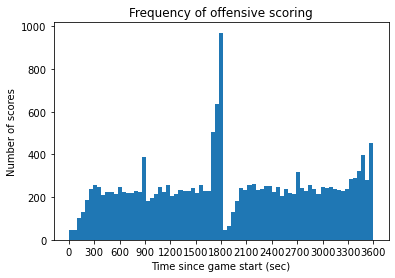

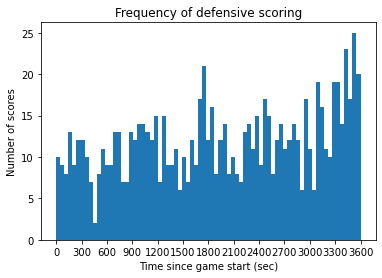

In [7]:
# plot frequency of offense scoring
pos_scores = []
for i in range(len(data)):
    if data.at[i, "posteam_scored"] and data.at[i, "game_time_sec"] <= 3600:
        pos_scores.append(data.at[i, "game_time_sec"])
plt.hist(pos_scores, bins=75)
plt.xticks(np.arange(0, 3601, 300))
plt.xlabel("Time since game start (sec)")
plt.ylabel("Number of scores")
plt.title("Frequency of offensive scoring")
plt.show()

# plot frequency of defense scoring
def_scores = []
for i in range(len(data)):
    if data.at[i, "defteam_scored"] and data.at[i, "game_time_sec"] <= 3600:
        def_scores.append(data.at[i, "game_time_sec"])
plt.hist(def_scores, bins=75)
plt.xticks(np.arange(0, 3601, 300))
plt.xlabel("Time since game start (sec)")
plt.ylabel("Number of scores")
plt.title("Frequency of defensive scoring")
plt.show()

There are a number of features in the above graphs that can be discussed, but many may not be surprising to football fans. The first obvious item that can be seen is the large spike in the middle of the offensive scoring graph. This spike is easily 4 to 5 times larger than the graph at almost any other time of the game. This spike takes place right before 1800 seconds, which is the end of the first half of the game. After half of the game, it does not matter who has the ball, as a kickoff always starts off the second half, so teams want to score if they have the ball at this time. This large spike shows that this is a very heavy source of encouragement, as teams seem to love to score at this time. A similar, yet smaller, spike can also be seen at the end of the first quarter (900 seconds), and an increase at the end of the game. The spike at the end of the first quarter is somewhat surprising, as the team that has the ball at that time will continue to have possession into the second quarter. As for the increase at the end of the game, teams who are losing the game by a small margin have a very large incentive to score at this time, as it could win them the game.

In the defensive graph, there are still a few spikes, but they are relatively much smaller. The only noticeable spikes that can be seen in this graph are at halftime and the end of the game. These peaks are likely for much of the same reasons as for the offensive graph. For the rest of the time in the game, we can see in both graphs that the frequency does not vary much. This is because teams are always wanting to score. One major difference that can be seen in comparing the graphs is that defenses score far fewer times than offenses. This is because turnovers happen few times per game, even fewer directly resulting in points.

### Pass vs run

Next we will compare the frequencies of the two main play types, pass and run. In any regular offensive play during the game, almost all plays will be a pass or a run, so it would be interesting to see if one type was significantly more prevalent than the other. First, we will find the number of each type of play.

In [8]:
# find number of pass and run plays
num_pass = len(data["PlayType"][data["PlayType"]=="Pass"])
num_run = len(data["PlayType"][data["PlayType"]=="Run"])
print("Number of pass plays:", num_pass)
print("Number of run plays:", num_run)

Number of pass plays: 159353
Number of run plays: 120831


We can see that there are about 40,000 more pass plays than runs, but we do not know how statistically significant this difference is. We are in luck, as there is indeed a way to see if this is a statistically significant difference: the binomial test. We make our null hypothesis $H_0$: There is no bias towards either play type. Our alternate hypothesis is $H_1$: Plays are biased towards passing. If the p-value we get from the binomial test is less than 0.05, we can reject our null hypothesis.

In [9]:
# perform a binomial test on the number of passing and rushing plays
print("Binomial test p value:", scipy.stats.binom_test([num_pass, num_run]))

Binomial test p value: 5e-323


As we can see, the p-value is much smaller than 0.05, meaning that there is a statistically significant difference. We can thus conclude that in the NFL in general, teams are more likely to pass the ball than run a statistically significant amount of the time.

### Interceptions

Interceptions are one of two types of turnovers in this sport, and only happen on one type of play, whereas the other type of turnover, fumbles, can happen at any time. Because interceptions are limited to passing plays, we are able to better categorize when and where they occur. Along with a classifier on whether or not there was an interception, our data tells us where the pass was intended to go, both in depth and direction. The data tells us whether the pass was a deep pass or a shorter pass, and which direction from the quarterback's point of view the pass went. We do not know exactly what the cutoffs for each classification are, but we can still use them to get a good idea as to where the ball went. In order to investigate this, we will create 3 heatmaps. The first heatmap will show the number of passes attempted in each region, the second will show the number of passes intercepted in each region, and the third will show the proportion of passes in each region that were intercepted.

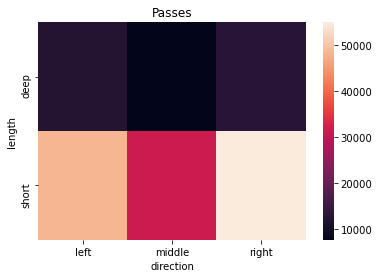

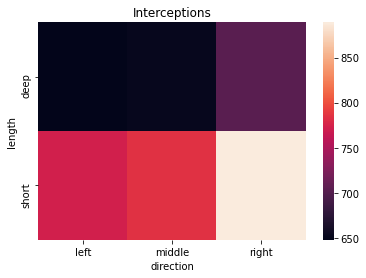

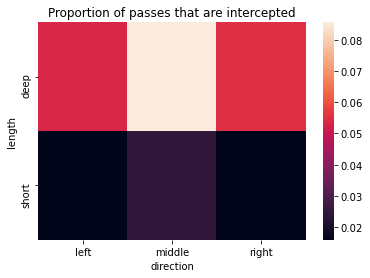

In [10]:
# get short and deep passes
spass = data["PassLocation"][data["PassLength"]=="Short"]
dpass = data["PassLocation"][data["PassLength"]=="Deep"]

# get only interceptions, split into short and deep passes
interceptions = data[data["InterceptionThrown"]==1].reset_index().drop("index", axis=1)
short_int = interceptions[interceptions["PassLength"]=="Short"]["PassLocation"]
deep_int = interceptions[interceptions["PassLength"]=="Deep"]["PassLocation"]

# count passes in each region
pass_loc = [[0, 0, 0], [0, 0, 0]]
pass_loc[0][0] = dpass.value_counts()["left"]
pass_loc[0][1] = dpass.value_counts()["middle"]
pass_loc[0][2] = dpass.value_counts()["right"]
pass_loc[1][0] = spass.value_counts()["left"]
pass_loc[1][1] = spass.value_counts()["middle"]
pass_loc[1][2] = spass.value_counts()["right"]

# count interceptions in each region
int_loc = [[0, 0, 0], [0, 0, 0]]
int_loc[0][0] = deep_int.value_counts()["left"]
int_loc[0][1] = deep_int.value_counts()["middle"]
int_loc[0][2] = deep_int.value_counts()["right"]
int_loc[1][0] = short_int.value_counts()["left"]
int_loc[1][1] = short_int.value_counts()["middle"]
int_loc[1][2] = short_int.value_counts()["right"]

# divide interception counts by total passes in region
int_prop = [[0, 0, 0], [0, 0, 0]]
for i in range(len(int_loc)):
    for j in range(len(int_loc[i])):
        int_prop[i][j] = int_loc[i][j] / pass_loc[i][j]

# create heatmaps
x_l = ("left", "middle", "right")
y_l = ("deep", "short")
seaborn.heatmap(pass_loc, xticklabels=x_l, yticklabels=y_l).set_title("Passes")
plt.xlabel("direction")
plt.ylabel("length")
plt.show()
seaborn.heatmap(int_loc, xticklabels=x_l, yticklabels=y_l).set_title("Interceptions")
plt.xlabel("direction")
plt.ylabel("length")
plt.show()
seaborn.heatmap(int_prop, xticklabels=x_l, yticklabels=y_l).set_title("Proportion of passes that are intercepted")
plt.xlabel("direction")
plt.ylabel("length")
plt.show()

In the heatmaps above, the lighter colors indicate a larger number of the statistic shown, while the darker colors indicate a smaller number.

In the first heatmap, we see that many more passes are thrown a short distance than deep. We can also see that the number of passes to the sides of the field is a good amount larger than the number thrown to the middle. Many more passes are likely to be thrown a short distance, as it is less risky than to throw the ball far down the field. As for the difference in side vs middle, there are a couple potential explanations. First, we have the common type of pass called a screen. In the screen pass, the quarterback throws a short pass to a player to his side, behind the line of scrimmage (where the play starts). The second explanation is related to stopping the clock. If a player runs out of bounds with the ball, their team gets the ball at that spot, but the game clock stops. This means that if a team has little time left but wants to score, they may try to throw the ball to the sideline in attempts to get out of bounds upfield, to both advance and stop the clock. Finally, there is one more feature of the heatmap we can comment on. We can see that there is a slight difference in shades of color between passes to the short left and short right. This color difference shows us that there are more passes thrown to the right in a short range than to the left. The most likely reason for this difference is that almost every single quarterback in the NFL is right handed. Because of how they hold the football, this means that most quarterbacks will be able to see the right side of the field much easier than the left side. This means that they will be more confident in throwing it to this side, as they can see more of what is going on.

As we can see in the second heatmap, while moving from deep passes to the left side towards shorter passes to the right, the number of interceptions increases. On its own, this may lead one to believe that many more passes that are shorter and to the right are intercepted than on the opposite side of the field, but pairing this data with the passes thrown can give us a much better idea of this statistic. While more passes to the short right are intercepted, we can see in the first heatmap that more passes are thrown to that area. This leads us to the third heatmap.

The third heatmap uses the first two datasets to give us a better idea how frequently passes in each region are intercepted. This heatmap shows us that a higher percentage of passes are intercepted when thrown deep than when thrown short, and more are intercepted in the middle of the field compared to the sides of the field. This shows us that either quarterbacks are better at getting the ball to their target in a shorter distance than longer distance, or defenses are better at intercepting deep passes, as they have more time to see the ball. It also tells us that fewer passes are intercepted on the sides of the field. While there are not as many explanations for this, a potential one is the prevalence of sideline catches that are difficult enough to catch for the indended receiver, and perhaps tougher still for the defender.

# Model Creation and Analysis

### Game Statistics

In order to investigate other topics related to this data, we will convert the data into data for each game in our dataset. This will allow us to compare games as a whole, and perform analysis related to who wins the game. In order to convert our play by play data into data for whole games, we must first break down our dataset into chunks based on which game they correspond to. Next, we must go through all of the data and add all of the necessary numbers to get the total stats for each game, which we then store in our new dataframe.

In [11]:
# function to get stats for below code
# most just add numbers from a column in dataset, some partially rely on others
# indices of ret correspond to indices of the statistics in cols
def get_append_data(tdata, odata, alld, team, cols):
    ret = [0 for i in range(22)]
    pdata = tdata[(tdata["PlayType"]=="Pass")|(tdata["PlayType"]=="Run")|(tdata["PlayType"]=="Sack")]
    opdata = odata[(odata["PlayType"]=="Pass")|(odata["PlayType"]=="Run")|(odata["PlayType"]=="Sack")]
    ret[2] = pdata[pdata["RushAttempt"]==1]["Yards.Gained"].sum()
    ret[1] = pdata["Yards.Gained"].sum() - ret[2]
    ret[0] = ret[1] + ret[2]
    ret[3] = pdata[pdata["turnover"]==0]["Touchdown"].sum() + opdata[opdata["turnover"]==1]["Touchdown"].sum()
    ret[3] += odata[odata["PlayType"]=="Kickoff"]["Touchdown"].sum() + odata[odata["PlayType"]=="Punt"]["Touchdown"].sum()
    ret[4] = odata["Safety"].sum()
    ret[5] = tdata["Onsidekick"].sum()
    ret[6] = len(pdata[pdata["PassAttempt"]==1])
    ret[7] = len(pdata[pdata["RushAttempt"]==1])
    ret[8] = tdata["InterceptionThrown"].sum()
    ret[9] = tdata["Fumble"].sum()
    ret[10] = tdata["turnover"].sum()
    ret[11] = len(tdata[tdata["ExPointResult"]=="Made"])
    ret[12] = ret[11] + len(tdata[tdata["ExPointResult"]=="Missed"]) + len(tdata[tdata["ExPointResult"]=="Blocked"])
    ret[13] = len(tdata[tdata["TwoPointConv"]=="Success"])
    ret[14] = ret[13] + len(tdata[tdata["TwoPointConv"]=="Failure"])
    ret[15] = len(tdata[tdata["FieldGoalResult"]=="Good"])
    ret[16] = ret[15] + len(tdata[tdata["FieldGoalResult"]=="No Good"]) + len(tdata[tdata["FieldGoalResult"]=="Blocked"])
    ret[17] = int(tdata["PosTeamScore"].max())
    ret[18] = odata["Sack"].sum()
    tpen = pd.concat([tdata[tdata["PenalizedTeam"]==team], odata[odata["PenalizedTeam"]==team]], ignore_index=True)
    ret[19] = len(tpen)
    ret[20] = tpen["Penalty.Yards"].sum()
    oscore = int(odata["PosTeamScore"].max())
    
    # add points for plays that are the last play of the game
    last = alld.iloc[-1]
    if last["posteam"] == team:
        if last["ExPointResult"] == "Made":
            ret[17] += 1
        elif last["TwoPointConv"] == "Success":
            ret[17] += 2
        elif last["Safety"] == 1:
            oscore += 2
        elif last["FieldGoalResult"] == "Good":
            ret[17] += 3
        elif last["Touchdown"] == 1 and last["turnover"] == 0:
            ret[17] += 6
        elif last["Touchdown"] == 1 and (last["turnover"] == 1 or last["PlayType"] in ("Kickoff", "Punt")):
            oscore += 6
    else:
        if last["ExPointResult"] == "Made":
            oscore += 1
        elif last["TwoPointConv"] == "Success":
            oscore += 2
        elif last["Safety"] == 1:
            ret[17] += 2
        elif last["FieldGoalResult"] == "Good":
            oscore += 3
        elif last["Touchdown"] == 1 and last["turnover"] == 0:
            oscore += 6
        elif last["Touchdown"] == 1 and (last["turnover"] == 1 or last["PlayType"] in ("Kickoff", "Punt")):
            ret[17] += 6
    if ret[17] > oscore:
        ret[21] = 1
    elif ret[17] == oscore:
        ret[21] = 0.5
    else:
        ret[21] = 0
    
    # use found values along with column names to return dictionary so we can put stats into dataframe
    return dict(zip(cols, ret))

In [12]:
# name columns of data we want to have for each game
cols = ("total_yards", "pass_yards", "rush_yards", "touchdowns", "safeties_scored", "onside_kicks",\
        "pass_plays", "run_plays", "interceptions_thrown", "fumbles", "turnovers", "extra_points", "ep_att", "two_points",\
        "tp_att", "fieldgoals", "fg_att", "score", "sacks", "penalties", "pen_yards", "winner", "team", "home_team", "id")

# create dataframes for home and away team statistics
game_data = pd.DataFrame(columns=cols)

# find data for game, then divide into home and away data
# then calculate all statistics
for game in data["GameID"].unique():
    # get data for this game, and split into home and away team data
    gdata = data[data["GameID"]==game].reset_index().drop("index", axis=1)
    hdata = gdata[gdata["posteam"]==gdata["HomeTeam"]].reset_index().drop("index", axis=1)
    adata = gdata[gdata["posteam"]==gdata["AwayTeam"]].reset_index().drop("index", axis=1)
    
    # find stats for home team and add to dataframe
    happ = get_append_data(hdata, adata, gdata, gdata.at[0, "HomeTeam"], cols)
    happ.update({"team": gdata.at[0, "HomeTeam"], "home_team": 1, "id": game})
    game_data = game_data.append(happ, ignore_index=True)
    
    # find stats for away team and add to dataframe
    aapp = get_append_data(adata, hdata, gdata, gdata.at[0, "AwayTeam"], cols)
    aapp.update({"team": gdata.at[0, "AwayTeam"], "home_team": 0, "id": game})
    game_data = game_data.append(aapp, ignore_index=True)

# show first 4 games
game_data.head(n=8)

,total_yards,pass_yards,rush_yards,touchdowns,safeties_scored,onside_kicks,pass_plays,run_plays,interceptions_thrown,fumbles,turnovers,extra_points,ep_att,two_points,tp_att,fieldgoals,fg_att,score,sacks,penalties,pen_yards,winner,team,home_team,id
0,357,321,36,1,0,0,43,23,2,2,3,1,1,0,0,2,2,13,1,6,60,1,PIT,1,2009091000
1,320,234,86,1,0,0,35,25,1,1,2,1,1,0,0,1,3,10,4,5,28,0,TEN,0,2009091000
2,270,181,89,2,0,1,35,20,1,3,2,1,1,0,0,2,2,18,4,8,66,0,CLE,1,2009091304
3,311,85,226,4,0,1,22,36,0,0,0,4,4,0,0,2,2,34,5,3,38,1,MIN,0,2009091304
4,515,358,157,6,0,0,34,35,1,1,2,6,6,0,0,1,2,45,1,7,36,1,NO,1,2009091307
5,294,260,34,3,0,0,37,19,3,1,3,2,2,0,0,2,2,26,0,8,80,0,DET,0,2009091307
6,451,277,174,4,0,0,42,31,1,1,1,3,3,0,0,0,2,20,1,3,15,0,TB,1,2009091308
7,473,344,129,4,0,1,27,24,0,0,0,4,4,0,0,2,2,34,0,4,41,1,DAL,0,2009091308


We have now converted all of our data that details each play individually into data that describes whole NFL football games. In the table above, we can see the statistics that we have found in our data for the first four games listed. There are two entries for each game: one for the home team, and one for the away team. With this data, we will be able to do more analysis, including attempting to create a model to predict who will win a game based on certain parameters.

Our first investigation with this new dataset will be to look at the ending scores of the games. There are a number of different ways we can look at this data. First, we will look at the overall distribution of scores with a histogram.

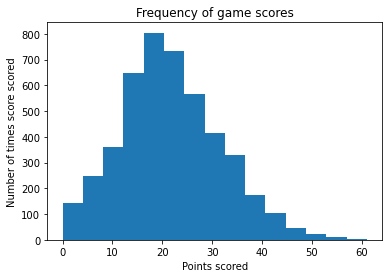

In [13]:
# plot score frequencies
plt.hist(game_data["score"], bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores")
plt.show()

In the graph above, we can see that the game scores are somewhat normally distributed (in reality they are not, as there are spikes every 3 or 7 points because of how scoring works). We see that the center of this distribution is slightly over 20 points.

We will next compare both home and away scores, and winning and losing scores. We will also graph the frequencies of scores of tie games. It should be expected that the winning scores are generally larger than the losing scores, and we will hopefully see the presence of "home field advantage."

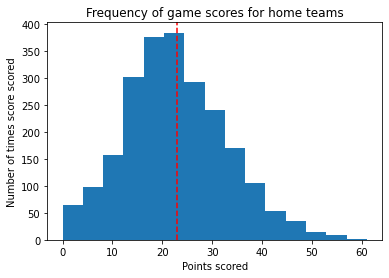

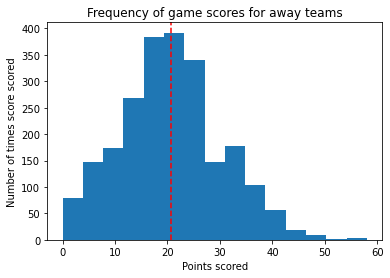

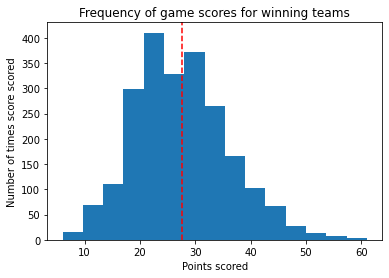

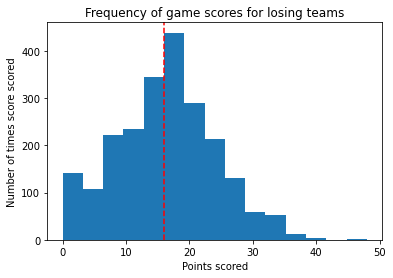

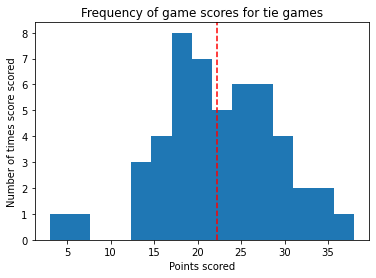

In [14]:
# plot home score frequencies
x = game_data[game_data["home_team"]==1]["score"]
plt.hist(x, bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores for home teams")
plt.axvline(x.mean(), color='r', linestyle='dashed')
plt.show()

# plot away score frequencies
x = game_data[game_data["home_team"]==0]["score"]
plt.hist(x, bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores for away teams")
plt.axvline(x.mean(), color='r', linestyle='dashed')
plt.show()

# plot winning score frequencies
x = game_data[game_data["winner"]==1]["score"]
plt.hist(x, bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores for winning teams")
plt.axvline(x.mean(), color='r', linestyle='dashed')
plt.show()

# plot losing score frequencies
x = game_data[game_data["winner"]==0]["score"]
plt.hist(x, bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores for losing teams")
plt.axvline(x.mean(), color='r', linestyle='dashed')
plt.show()

# plot tie score frequencies
x = game_data[(game_data["home_team"]==1)&(game_data["winner"]==0.5)]["score"]
plt.hist(x, bins=15)
plt.xlabel("Points scored")
plt.ylabel("Number of times score scored")
plt.title("Frequency of game scores for tie games")
plt.axvline(x.mean(), color='r', linestyle='dashed')
plt.show()

In each of the above graphs, the mean is plotted with the red dashed line. When comparing home and away scores, we can see that the average home team scores every so slightly more than the away team. While this difference may not seem like much, it is interesting that the home team graph has noticeably more scores at higher levels, and less at lower levels. The differences in the winning and losing graphs are much easier to see. With these two graphs, the same differences appear as in the previous two, but the differences are larger. This should be expected, as to win a game, you must score more points than the other team. As for the tie game points, we have an interesting spread. It can be seen that there is a small hump around 5 (likely at 3 and 7 points for the most part), while almost all of the other scores are above 12-13. This is interesting, as one would assume that there would be more lower scoring tie games, as if teams are evenly matched, there is a good chance neither will score, or score few points. As we can see, this does not happen as much as you would expect. Instead, we see many tie scores at 20 and slightly below, and between 25 and 30. As we can see in the other graphs, most scores for any game range from just under 20 up to close to 30. This is echoed in the tie game scores, meaning that instead of holding the other team to few scores, in tie games both teams often score a few times each, while not letting the other score too much.

### Game Result Predictions

Next and finally, we will attempt to create a model that predicts the winner of an NFL game, based on certain statistics. The statistics we will include are all of those in the $game\_data$ dataframe, minus the statistics that directly tell us how many points a team has scored. These stats will be removed, as if the model knows how many points a team has scored, it can immediately know who has won. We will also remove the winner, team, and id columns, as we do not want either of those to have any bearing on the prediction. We will use a [random forest](https://en.wikipedia.org/wiki/Random_forest) to create our prediction model, and 10-fold cross-validation to test the prediction strength. As the data we are currently using has one row for each team, our model will predict if a team has won based on their statistics.

Before passing our data into our model, we must remove the scoring, winner, team, and id columns. We will thus create a method to simply drop those columns from the dataframe.

In [15]:
# function deletes columns not wanted for prediction model
def strip_cols(df):
    cols_to_delete = ("touchdowns", "safeties_scored", "extra_points", "ep_att", "two_points", "tp_att",\
                      "fieldgoals", "fg_att", "score", "winner", "team", "id")
    for col in cols_to_delete:
        df = df.drop(col, axis=1)
    return df

In [16]:
# get predictors and values to predict
y_data = game_data["winner"].astype("int")
x_data = strip_cols(game_data)
x_data.head(n=4)

,total_yards,pass_yards,rush_yards,onside_kicks,pass_plays,run_plays,interceptions_thrown,fumbles,turnovers,sacks,penalties,pen_yards,home_team
0,357,321,36,0,43,23,2,2,3,1,6,60,1
1,320,234,86,0,35,25,1,1,2,4,5,28,0
2,270,181,89,1,35,20,1,3,2,4,8,66,1
3,311,85,226,1,22,36,0,0,0,5,3,38,0


In [17]:
# create random forest
rfor = RandomForestClassifier(n_estimators=150)

In [18]:
# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)
rfor_scores = cross_val_score(rfor, x_data, y_data, cv=kf)
print("Average score:", np.mean(rfor_scores))
print("Standard deviation:", np.std(rfor_scores))

Average score: 0.7990497972271997
Standard deviation: 0.014786097641217754


The above average 10-fold cross-validation score for our random forest shows that our model can predict with almost 80% accuracy if a team has won a game, based on the statistics given. The small standard deviation shows us that this accuracy level does not vary much. We should feel very good about this accuracy level, as it is hard to predict this as a human looking at the data given, and 80% is a good percentage to have gotten correct.

Now that we have our model, we will use it to predict the outcomes of each of the two Baltimore Ravens vs Cleveland Browns games in the 2020 NFL season. One of these games was one sided (38-6), while the other was much closer (47-42). If our model is able to correctly predict both outcomes, we can see proof that it works well. In order to find the statistics for these games, I used [ESPN](https://espn.com), a major sports channel. The statistics for each of the games can be found here: [Game 1](https://www.espn.com/nfl/matchup?gameId=401220147), [Game 2](https://www.espn.com/nfl/matchup?gameId=401220162).

In [19]:
# input statistics for each game as reported by ESPN
game1_bal = [381, 270, 111, 5, 0, 0, 26, 30, 0, 2, 1, 5, 5, 0, 0, 1, 1, 38, 2, 7, 66, 1, "BAL", 1, 1]
game1_cle = [306, 168, 138, 1, 0, 0, 39, 27, 1, 3, 3, 0, 1, 0, 0, 0, 1, 6, 2, 8, 80, 0, "CLE", 0, 1]
game2_bal = [385, 154, 231, 6, 1, 0, 21, 32, 0, 1, 0, 4, 5, 1, 1, 1, 1, 47, 0, 8, 69, 1, "BAL", 0, 2]
game2_cle = [493, 355, 138, 6, 0, 0, 48, 28, 1, 7, 1, 4, 5, 1, 1, 0, 1, 42, 4, 8, 75, 0, "CLE", 1, 2]

# create dataframe to hold data, then add data
games_to_predict = pd.DataFrame(columns=cols)
games_to_predict = games_to_predict.append(dict(zip(cols, game1_bal)), ignore_index=True)
games_to_predict = games_to_predict.append(dict(zip(cols, game1_cle)), ignore_index=True)
games_to_predict = games_to_predict.append(dict(zip(cols, game2_bal)), ignore_index=True)
games_to_predict = games_to_predict.append(dict(zip(cols, game2_cle)), ignore_index=True)

# get predictors and values to predict
true = games_to_predict["winner"]
predictors = strip_cols(games_to_predict)
predictors

,total_yards,pass_yards,rush_yards,onside_kicks,pass_plays,run_plays,interceptions_thrown,fumbles,turnovers,sacks,penalties,pen_yards,home_team
0,381,270,111,0,26,30,0,2,1,2,7,66,1
1,306,168,138,0,39,27,1,3,3,2,8,80,0
2,385,154,231,0,21,32,0,1,0,0,8,69,0
3,493,355,138,0,48,28,1,7,1,4,8,75,1


In [20]:
# predict outcomes for 2020 games
model = rfor.fit(x_data, y_data)
predictions = model.predict(predictors)
print("Predictions:", predictions)
print("True values:", np.array(true))

Predictions: [1 0 1 1]
True values: [1 0 1 0]


As we can see, our model predicted 3 out of the 4 outcomes correctly. This is good, but we can do better. This model predicts whether one team has won their game based on their statistics, not using the other team in the calculation. This can lead to situations where the model says that both or neither team has won in a certain game, which does not make sense, as exactly one team will win in a game (barring ties). If we then use the other team's statistics in the same row, we may be able to better predict the outcome of the game. That is what we will next do. In order to create this new model, we must transform our data. We need to combine every two rows into one row, in order to have one whole game's worth of information on a row. We can then do a similar process to create this second model that takes both team's statistics into account.

### Game Result Predictions With Both Team's Statistics

In [21]:
# this function moves every other row in a dataframe next to the row directly above it
# dataframe must have an even number of rows, otherwise an error will be thrown
def merge_row_pairs(old_df, new_df):
    # new labels are old labels with a 2 at the end
    cols2 = [*(cols[i] + "2" for i in range(len(cols)))]

    # for each pair of rows, save each as a dictionary and concatenate them
    # then put the new line with both team's statistics into the new dataframe
    for i in range(0, len(old_df), 2):
        dat = dict(zip(cols, np.array(old_df.iloc[i])))
        dat2 = dict(zip(cols2, np.array(old_df.iloc[i+1])))
        dat.update(dat2)
        new_df = new_df.append(dat, ignore_index=True)
    return new_df

In [22]:
# same idea as strip_cols, but removes columns for the second team in the row
def strip_cols2(df):
    cols_to_delete = ("touchdowns2", "safeties_scored2", "extra_points2", "ep_att2", "two_points2", "tp_att2",\
                      "fieldgoals2", "fg_att2", "score2", "winner2", "team2", "id2")
    for col in cols_to_delete:
        df = df.drop(col, axis=1)
    return df

In [23]:
# merge row pairs for game data
game_data2 = pd.DataFrame()
game_data2 = merge_row_pairs(game_data, game_data2)

# get predictors and values to predict
# we will simply predict if the first team is the winner
y_data = game_data2["winner"].astype("int")
x_data = strip_cols(strip_cols2(game_data2))
x_data.head(n=4)

,fumbles,fumbles2,home_team,home_team2,interceptions_thrown,interceptions_thrown2,onside_kicks,onside_kicks2,pass_plays,pass_plays2,pass_yards,pass_yards2,pen_yards,pen_yards2,penalties,penalties2,run_plays,run_plays2,rush_yards,rush_yards2,sacks,sacks2,total_yards,total_yards2,turnovers,turnovers2
0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,43.0,35.0,321.0,234.0,60.0,28.0,6.0,5.0,23.0,25.0,36.0,86.0,1.0,4.0,357.0,320.0,3.0,2.0
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,35.0,22.0,181.0,85.0,66.0,38.0,8.0,3.0,20.0,36.0,89.0,226.0,4.0,5.0,270.0,311.0,2.0,0.0
2,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,34.0,37.0,358.0,260.0,36.0,80.0,7.0,8.0,35.0,19.0,157.0,34.0,1.0,0.0,515.0,294.0,2.0,3.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,42.0,27.0,277.0,344.0,15.0,41.0,3.0,4.0,31.0,24.0,174.0,129.0,1.0,0.0,451.0,473.0,1.0,0.0


In [24]:
# create random forest
rfor = RandomForestClassifier(n_estimators=150)

In [25]:
# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)
rfor_scores = cross_val_score(rfor, x_data, y_data, cv=kf)
print("Average score:", np.mean(rfor_scores))
print("Standard deviation:", np.std(rfor_scores))

Average score: 0.8468134763786936
Standard deviation: 0.022048594570707673


The above average score shows us that this new model is actually better at predicting the outcome of a game than our old model, by about 5%. This model has an accuracy of almost 85%, again with a very small standard deviation.

Now that we have our new model that uses statistics from both teams, we can repredict the results of the two Baltimore Ravens vs Cleveland Browns games from the 2020 season.

In [26]:
# merge row pairs for Ravens vs Browns game data
games_to_predict2 = pd.DataFrame()
games_to_predict2 = merge_row_pairs(games_to_predict, games_to_predict2)

# get predictors and values to predict
true = games_to_predict2["winner"]
predictors = strip_cols(strip_cols2(games_to_predict2))
predictors

,fumbles,fumbles2,home_team,home_team2,interceptions_thrown,interceptions_thrown2,onside_kicks,onside_kicks2,pass_plays,pass_plays2,pass_yards,pass_yards2,pen_yards,pen_yards2,penalties,penalties2,run_plays,run_plays2,rush_yards,rush_yards2,sacks,sacks2,total_yards,total_yards2,turnovers,turnovers2
0,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,26.0,39.0,270.0,168.0,66.0,80.0,7.0,8.0,30.0,27.0,111.0,138.0,2.0,2.0,381.0,306.0,1.0,3.0
1,1.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0,21.0,48.0,154.0,355.0,69.0,75.0,8.0,8.0,32.0,28.0,231.0,138.0,0.0,4.0,385.0,493.0,0.0,1.0


In [27]:
# predict outcomes for 2020 games
model = rfor.fit(x_data, y_data)
predictions = model.predict(predictors)
print("Predictions:", predictions)
print("True values:", np.array(true))

Predictions: [1 1]
True values: [1. 1.]


As we can see, this model correctly predicted the results of both games. This is very good. Looking at the statistics for the second game, one could potentially think that the second team (the Cleveland Browns) won the game, as they had a good amount more yards than the opponent, along with more plays. These two facts generally mean that this team would have had possession of the ball for more time, which can be a decent predictor of winning a game. The random forest, however, analyzed all of the data and found that this did not apply to this game, correctly identifying the Baltimore Ravens as the winning team.

### Important Game Statistics?

We now have a model that does a pretty good job predicting which team is the winner, but it would be interesting to see which statistics are considered more important in terms of predicting the outcome of a game. To find out which stats are important, we can use a logistic regression model. Because some stats are wildly different from others, we will first scale the data to make everything go smoothly. Below, we create a logistic regression model (accuracy found again with 10-fold cross-validation) and look at the weights to see which stats have higher weights in the prediction.

In [28]:
# scale data and do 10-fold cross validation on logistic regression
x_scaled = preprocessing.scale(x_data)
lg = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True)
lg_scores = cross_val_score(lg, x_scaled, y_data, cv=kf)
print("Average score:", np.mean(lg_scores))
print("Standard deviation:", np.std(lg_scores))

Average score: 0.8689252776209297
Standard deviation: 0.015492589021967151


In [29]:
# create dictionary of weights with their corresponding statistic
# then find 4 statistics with the largest positive weights, and 4 with the largest negative weights
weights_dict = dict(zip(x_data.columns, lg.fit(x_scaled, y_data).coef_[0]))
pos4 = Counter(weights_dict).most_common(4)
neg4 = Counter(weights_dict).most_common()[-4:]
print("Positive 4:")
for k, v in pos4:
    print(k+":", round(v, 3))
print("\nNegative 4:")
for k, v in neg4[::-1]:
    print(k+":", round(v, 3))

Positive 4:
pass_yards: 0.815
total_yards: 0.763
pass_plays2: 0.76
turnovers2: 0.658

Negative 4:
pass_plays: -1.034
total_yards2: -0.74
turnovers: -0.714
pass_yards2: -0.713


From the average cross-validation score, we can see that this model is at least as accurate as the previous. When looking at the weights, we must remember what is being predicted: if the first team has won. Looking at the top 4 weights in each direction with this in mind, we can see what are potentially the most important statistics with which we can judge the outcome of a game. One of the first things that we can notice about these two lists is that they contain the same statistics, but for opposite teams. If we think about it, this makes sense, as if a team having more of a certain stat being good for them, it would logically follow that it would not be good for the other team to have less.

Looking at the actual statistic items, we see three that would make sense to be good for team one, but the other is not as apparent. More passing yards (and total yards) and opponent turnovers are generally regarded as numbers that a team would want higher, but opponent passing attempts may not be something initially thought of in this way. If we think about passing yards and passing attempts together, however, we may be able to figure out why the model suggests this. If one team has more passing yards and less passing attempts, this means that they have more passing yards per attempt. While passing attempts on its own is not necessarily a good predictor of winning, combining it with passing yards to get yards per attempt can be beneficial, as more passing yards per pass attempt is definitely a good indicator of success on the football field.

### Try to Predict Yourself!

Using a simplified version of the above list, we can try to predict the winner of an NFL game on our own, without a computer model (the method, however, we got from the computer model). This method is not guaranteed to work, but based on the model's accuracy score, we can expect to be right most of the time. In order to try this out for yourself, follow the below steps:

1. Find the box score for any NFL game
2. Designate one team as team 1, and the other as team 2
3. For the following statistic-team combinations, mark a (+1) if that team has a greater statistic value than the other team, a (-1) if they have less, and 0 if they are equal: <br>
    a. Passing yards, team 1 <br>
    b. Total yards, team 1 <br>
    c. Passing attempts, team 2 <br>
    d. Turnovers, team 2 <br>
4. Interpret your prediction- add the four numbers together, and compare to the three potential results below: <br>
    a. Negative number: team 1 lost <br>
    b. Zero: close game or tie <br>
    c. Positive number: team 1 won

Again, this method will not always work, but it should surprisingly work most of the time. Because we have simplified the model a lot, it will not be as good as the model itself, but because it is based off of the model, it should be significantly better than randomly predicting the winner.

# Insight

Hopefully, you learned at least a little bit about some of the reasons why certain things happen in football games, including when teams score, preferences between passing and running the ball, and where interceptions are a little more common.

We also made a couple of models to predict the winner of a game. The first one that we made accepted certain statistics about one team, and predicted if that team won the game, while the second accepted the same statistics but for both teams. Interestingly, the second model had a better accuracy by 5% (85% vs 80%). We also found that the four most important statistics based on our models are passing yards, total yards, passing attempts, and turnovers. There is definitely room to improve the accuracy of these models, as there are other statistics that we could add, such as the number of first downs. Additional research could also be done by using statistics known before a game in order to predict the outcome, such as statistics from previous games and which team is the favorite to win.

Thank you for reading and I hope this was both interesting and educational!